# Denoising visualization

In [58]:
import numpy as np
import sqlite3 as lite
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal

from utils.db_utils import create_db_with_tables, initialize_table_data, get_db_file_path
from utils.denoising_utils import wiener_filter, moving_average_filter
from utils.statistic_utils import hamming_weight__single, \
    hamming_weight__vector, cross_correlation_matrix, \
    pearson_correlation_coefficient, correlation_matrix, snr_calculator, root_mean_square
from utils.trace_utils import get_trace_set_metadata__depth, get_trace_set__processed, \
    get_trace_set_metadata__depth__processed

In [19]:
# Import noise data
project_dir = os.getenv("MASTER_THESIS_RESULTS")
noise_dir = os.path.join(project_dir, "datasets/test_traces/Zedigh_2021/office_corridor/Noise/data")
noise_traces_file_path = os.path.join(noise_dir, "traces.npy")
noise_traces_npy = np.load(noise_traces_file_path)
noise_traces_df = pd.DataFrame(noise_traces_npy)
noise_traces_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.000699,0.000707,0.000697,0.000728,0.000733,0.000695,0.000689,0.000692,0.000705,0.000696,...,0.000664,0.000690,0.000670,0.000682,0.000678,0.000674,0.000675,0.000667,0.000667,0.000665
std,0.000358,0.000361,0.000361,0.000372,0.000370,0.000356,0.000353,0.000353,0.000361,0.000358,...,0.000348,0.000355,0.000342,0.000353,0.000354,0.000352,0.000339,0.000348,0.000355,0.000358
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000031
25%,0.000432,0.000437,0.000432,0.000454,0.000458,0.000425,0.000425,0.000432,0.000428,0.000432,...,0.000401,0.000432,0.000411,0.000409,0.000411,0.000415,0.000427,0.000407,0.000407,0.000401
50%,0.000660,0.000671,0.000655,0.000686,0.000705,0.000657,0.000659,0.000652,0.000672,0.000656,...,0.000629,0.000649,0.000635,0.000644,0.000642,0.000637,0.000642,0.000629,0.000629,0.000618
75%,0.000928,0.000930,0.000918,0.000965,0.000970,0.000923,0.000910,0.000915,0.000930,0.000916,...,0.000874,0.000918,0.000886,0.000907,0.000902,0.000891,0.000889,0.000886,0.000890,0.000881
max,0.002497,0.003089,0.003247,0.003412,0.002534,0.002460,0.004364,0.004126,0.003665,0.003559,...,0.004696,0.005650,0.003091,0.002970,0.003095,0.003035,0.003941,0.004573,0.006293,0.007116


In [55]:
index_1 = int(512400 / 400)
index_2 = int(1824800 / 400)
traces_fixed = noise_traces_npy.copy()
traces_fixed[index_1] = traces_fixed[index_1 -20]
traces_fixed[index_2] = traces_fixed[index_2 -20]
noise_traces_flattened_fixed = traces_fixed.flatten()

4.2267906e-14


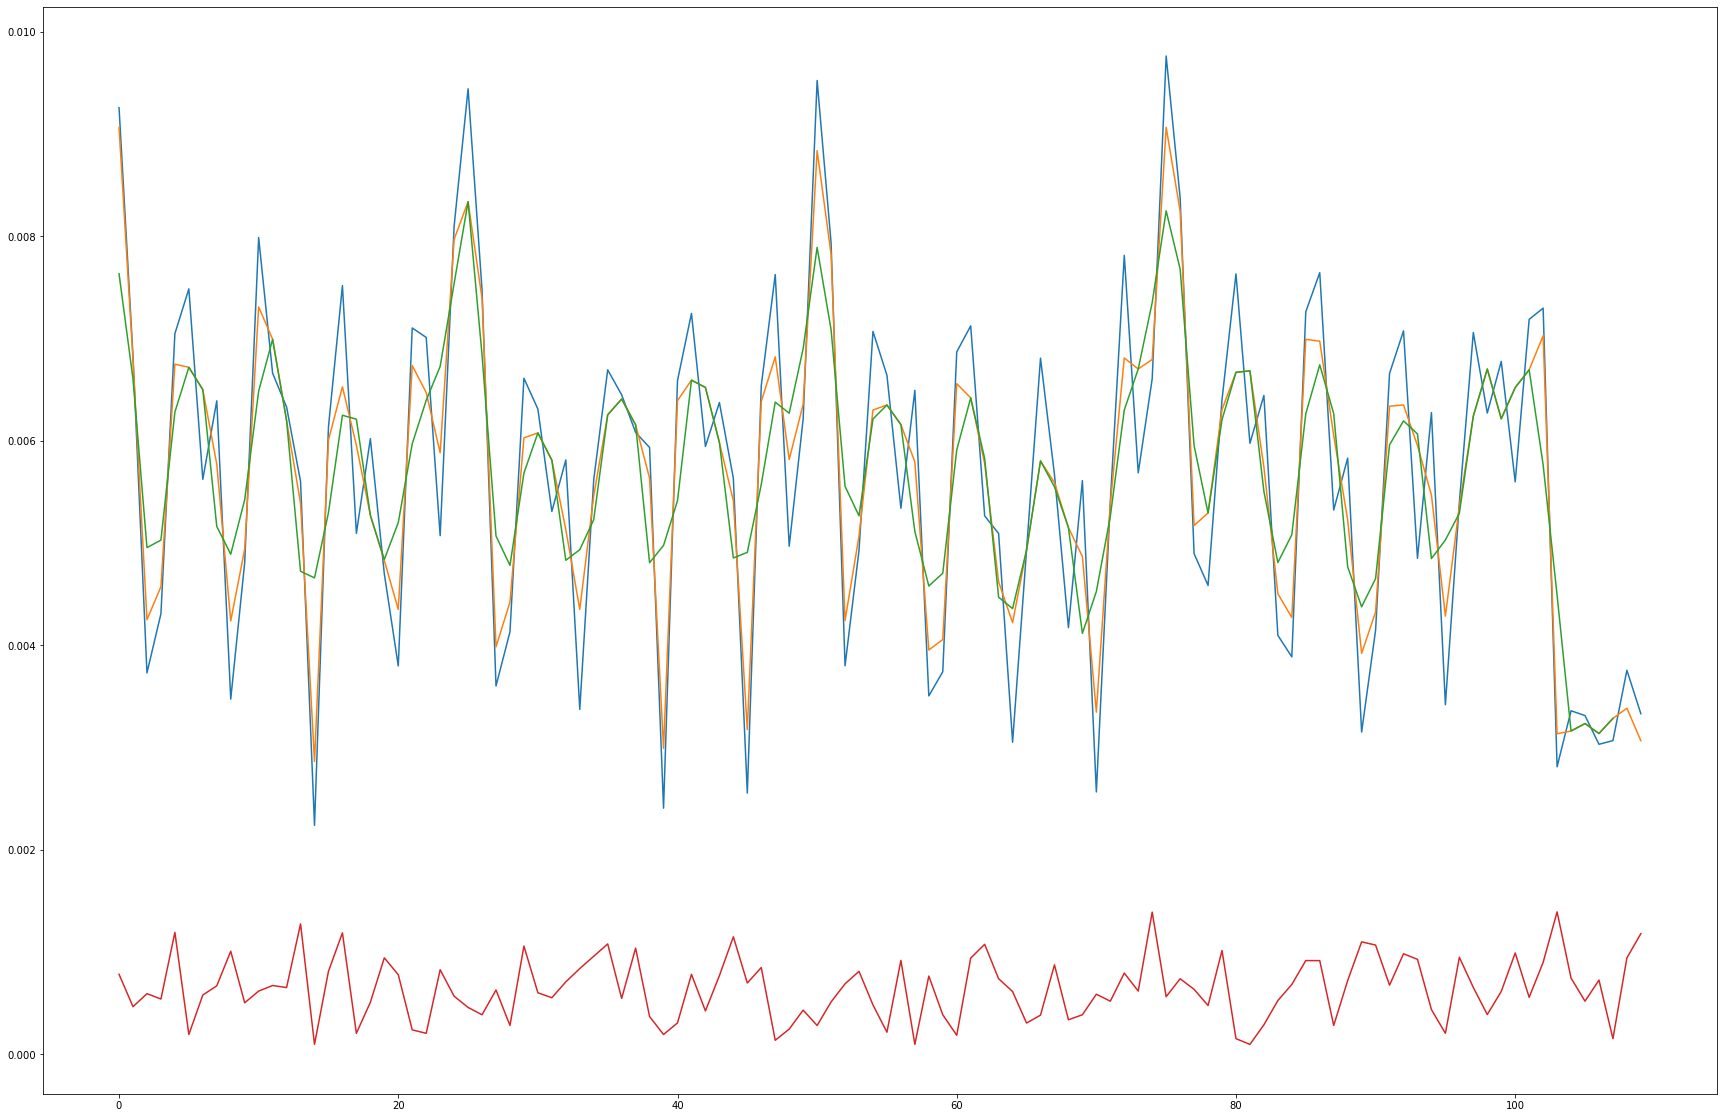

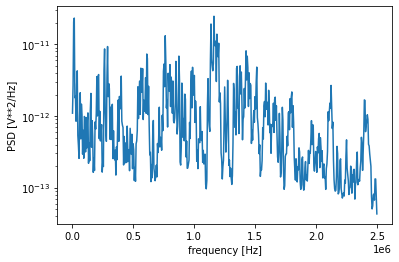

1.401461e-12
0.006137014826949119
0.0007677114822205795
63.90256235382443


In [61]:
def test_wiener_filter(trace_set, noise_trace, noise_power):
    plt.figure(figsize=(30,20))
    #plt.subplot(1, 2, 1)
    plt.plot(trace_set[2][204:314])
    filtered_trace = wiener_filter(trace_set[2][204:314], 0.0000007677114822205795)#noise_power)#4.2267906e-8)
    #plt.subplot(1, 2, 2)
    plt.plot(filtered_trace)
    maf_trace = moving_average_filter(trace_set[2][203:313], 3)
    plt.plot(maf_trace)
    plt.plot(noise_trace[:len(filtered_trace)])
    plt.show()

trace = get_trace_set__processed(
    "main.db",
    test_dataset_id=2,
    training_dataset_id=None,
    environment_id=1,
    distance=2,
    device=10,
    trace_process_id=2,
)

fs = 5e6
f, Pxx_den = signal.welch(noise_traces_flattened_fixed, fs, nperseg=1024, average="mean")
noise_power = np.mean(Pxx_den[256:512])
print(noise_power)
test_wiener_filter(trace, noise_traces_flattened_fixed, noise_power*1000)

f, Pxx_den = signal.welch(trace.flatten(), fs, nperseg=1024, average="mean")
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
noise_power = np.mean(Pxx_den)
print(noise_power)
print(root_mean_square(trace.flatten()))
print(root_mean_square(noise_traces_flattened_fixed))
print((root_mean_square(trace.flatten())/(root_mean_square(noise_traces_flattened_fixed)))**2)

In [38]:
4.2267906e-14/4.402244e-13

0.09601445535504166